<img src="monai.png" style="width: 700px;"/>

Welcome to the MONAI bootcamp! This notebook will introduce you to an end-to-end working in MONAI using a standard PyTorch loop.

### Using Google Colab

This notebook has the pip command for installing MONAI and will be added to any subsequent notebook.

**Required Packages for Colab Execution**

Execute the following cell to install MONAI the first time a colab notebook is run:


In [1]:
!python -c "import monai" || pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==1.0.0rc3"

**Enabling GPU Support**

To use GPU resources through Colab, change the runtime to GPU:

1. From the **"Runtime"** menu select **"Change Runtime Type"**
2. Choose **"GPU"** from the drop-down menu
3. Click **"SAVE"**

This will reset the notebook and probably ask you if you are a robot (these instructions assume you are not). Running

**!nvidia-smi**

in a cell will verify this has worked and show you what kind of hardware you have access to.    

In [ ]:
!nvidia-smi

# End-to-end Training with Pytorch
---

We've covered a lot of material and now it's time to apply the things that we've learned in an end-to-end example.  First, we're going to use the basic PyTorch paradigm for training our model.  We'll then look at how to train using the Ignite workflows to make things even easier!


## End-to-End Training Workflow

To help guide you through training your first model using MONAI, this guide will will cover five key phases:

1. **Setting up our Dataset and exploring the data**
2. **Preparing datasets and transforms**
3. **Define your network and create our PyTorch training loop**
4. **Evaluate your model and understand the results**

Let's get started by importing our dependencies.

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch
import monai

from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.data import decollate_batch, partition_dataset_classes
from monai.networks.nets import DenseNet121
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    Activations,
    AsDiscrete,
    EnsureType
)
from monai.utils import set_determinism

## **1. Setting up our Dataset and exploring the data**

#### Setup data directory

We'll create a temporary directory for all the MONAI data we're going to be using called MONAI_DATA_DIRECTORY.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpz2tz35gz


#### Download the MedNIST dataset
The `MedNIST` dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions),
[the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4),
and [the NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

The dataset is kindly made available by [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview) (Department of Radiology, Mayo Clinic)
under the Creative Commons [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/). If you use the MedNIST dataset, please acknowledge the source.

We're going to download this dataset below and extract it into our temporary MONAI Data Directory.

In [4]:
resource = "https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz?dl=1"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

MedNIST.tar.gz: 59.0MB [00:03, 16.2MB/s]                              

2022-09-15 20:56:47,340 - INFO - Downloaded: /tmp/tmpz2tz35gz/MedNIST.tar.gz


2022-09-15 20:56:47,448 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2022-09-15 20:56:47,449 - INFO - Writing into directory: /tmp/tmpz2tz35gz.


#### Set deterministic training for reproducibility
[set_determinism](https://docs.monai.io/en/latest/utils.html?highlight=set_determinism#monai.utils.misc.set_determinism) will set the random seeds in both Numpy and PyTorch to ensure reproducibility. We'll see later that we need to go a little bit further to ensure reproducibility in a jupyter notebook

In [5]:
set_determinism(seed=0)

#### Read the image filenames from the dataset folders

When using a dataset, you want to understand the basics of the images, labels, and more.  We'll start off by showing some of those basic statistics for MedNIST.

We'll see that 6 different folders are representing 6 different categories: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT.  We'll be using each of these categories as our label names. 

In [6]:
class_names = sorted(x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)

image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]

num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []

for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
    
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


#### Randomly pick images from the dataset to visualize and check

We want to understand what the images we're using look like, so we'll start by visualizing a few random images.

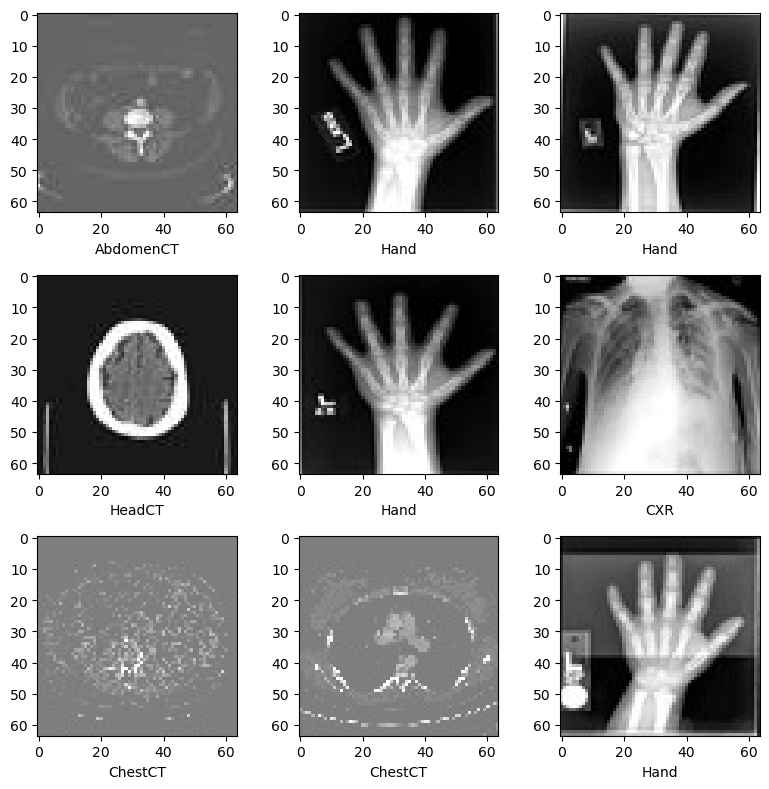

In [6]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## **2. Preparing datasets and transforms**

#### Prepare training, validation, and test data lists

We want to split the data into 3 different sets, one for training, one for validation, and one for testing.  We'll use a ratio of 80/10/10 for those sets.

In [7]:
train_inds, val_inds, test_inds = partition_dataset_classes(np.arange(len(image_files_list)), 
                                                            image_class,(8, 1, 1), shuffle=True)

train_x = [image_files_list[i] for i in train_inds]
train_y = [image_class[i] for i in train_inds]
val_x = [image_files_list[i] for i in val_inds]
val_y = [image_class[i] for i in val_inds]
test_x = [image_files_list[i] for i in test_inds]
test_y = [image_class[i] for i in test_inds]

print(f"Training count: {len(train_x)}, Validation count: {len(val_x)}, Test count: {len(test_x)}")

Training count: 47163, Validation count: 5895, Test count: 5895


#### Define MONAI transforms, Dataset and Dataloader to pre-process data

We'll define our transform using `Compose`.  In this Array of Transforms, we'll load the image, add a channel, scale its intensity, utilize a few random functions and finally create a tensor.

In [8]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        RandRotate(range_x=15, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

act = Compose([Activations(softmax=True)])
to_onehot = Compose([AsDiscrete(to_onehot=num_class)])

#### Initialise the datasets and loaders for training, validation and test sets
 * Define a simple dataset, that we'll call `MedNISTDataset`, that groups:
   * Images
   * Labels
   * The transforms that are to be run on the images and labels
 * Create three instances of this dataset:
   * One for training
   * One for validation
   * One for testing
   
We'll use a batch size of 512 and employ 10 workers to load the data.

In [9]:
batch_size = 512
num_workers = 10

class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers)

## **3. Define your network and create our PyTorch training loop**

#### Define network and optimizer

1. Set `learning_rate` for how much the model is updated per step
1. The fetch a pytorch `device` for the GPU
1. Instantiate a [densenet121](https://docs.monai.io/en/latest/networks.html?highlight=densenet#monai.networks.nets.densenet121) model instance and 'send' it to the GPU using `device`
  * This is a standard MONAI implementation; it is capable of 2D and 3D operation but here we are using it in 2D mode
1. We'll make use of the Adam optimizer

In [10]:
learning_rate = 1e-5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = DenseNet121(spatial_dims=2, in_channels=1, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), learning_rate)

#### Network training
We are hand-rolling a basic pytorch training loop here:
 * standard pytorch training loop
   * step through each training epoch, running through the training set in batches
   * after each epoch, run a validation pass, evaluating the network
   * if it shows improved performance, save out the model weights
 * later we will revisit training loops in a more Ignite / MONAI fashion

In [ ]:
epoch_num = 4
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
auc_metric = ROCAUCMetric()

for epoch in range(epoch_num):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")

    epoch_loss = 0
    step = 1

    steps_per_epoch = len(train_ds) // train_loader.batch_size

    # put the network in train mode; this tells the network and its modules to
    # enable training elements such as normalisation and dropout, where applicable
    net.train()
    for batch_data in train_loader:

        # move the data to the GPU
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)

        # prepare the gradients for this step's back propagation
        optimizer.zero_grad()
        
        # run the network forwards
        outputs = net(inputs)
        
        # run the loss function on the outputs
        loss = loss_function(outputs, labels)
        
        # compute the gradients
        loss.backward()
        
        # tell the optimizer to update the weights according to the gradients
        # and its internal optimisation strategy
        optimizer.step()

        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size + 1}, training_loss: {loss.item():.4f}")
        step += 1

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # after each epoch, run our metrics to evaluate it, and, if they are an improvement,
    # save the model out
    
    # switch off training features of the network for this pass
    net.eval()

    # 'with torch.no_grad()' switches off gradient calculation for the scope of its context
    with torch.no_grad():
        # create lists to which we will concatenate the the validation results
        preds = list()
        labels = list()

        # iterate over each batch of images and run them through the network in evaluation mode
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)

            # run the network
            val_pred = net(val_images)

            preds.append(val_pred)
            labels.append(val_labels)

        # concatenate the predicted labels with each other and the actual labels with each other
        y_pred = torch.cat(preds)
        y = torch.cat(labels)

        # we are using the area under the receiver operating characteristic (ROC) curve to determine
        # whether this epoch has improved the best performance of the network so far, in which case
        # we save the network in this state
        y_onehot = [to_onehot(i) for i in decollate_batch(y)]        
        y_pred_act = [act(i) for i in decollate_batch(y_pred)]
        
        auc_metric(y_pred_act, y_onehot)
        auc_value = auc_metric.aggregate()
        auc_metric.reset()
        metric_values.append(auc_value)
        
        acc_value = torch.eq(y_pred.argmax(dim=1), y)
        acc_metric = acc_value.sum().item() / len(acc_value)
        
        if auc_value > best_metric:
            best_metric = auc_value
            best_metric_epoch = epoch + 1
            torch.save(net.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
            print("saved new best metric network")
            
        print(
            f"current epoch: {epoch + 1} current AUC: {auc_value:.4f} /"
            f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f} /"
            f" at epoch: {best_metric_epoch}"
        )

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

#### Plot the loss and metric

Once we're done training we want to visualize our Loss and Accuracy.

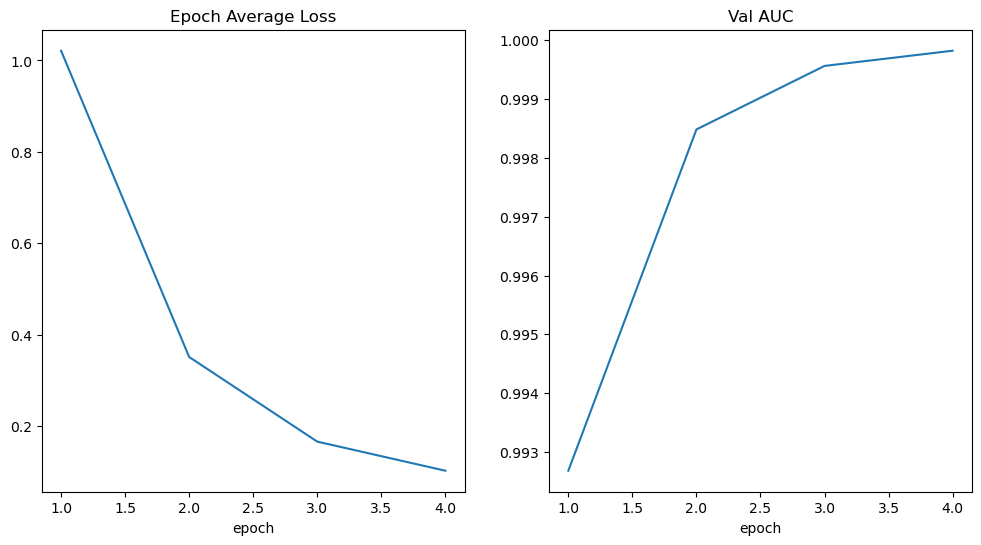

In [12]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [(i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## **4. Evaluate your model and understand the results**

#### Evaluate the model on the test dataset

After training and validation, we now have the best model as determined by the validation dataset.  But now we need to evaluate the model on the test dataset to check whether the final model is robust and not over-fitting.  We'll use these predictions to generate a classification report.

In [13]:
net.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
net.eval()
y_true = list()
y_pred = list()

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = net(test_images).argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

#### Some light analytics - classification report

We'll utilize scikit-learn's classification report to get the precision, recall, and f1-score for each category.

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.9809    0.9740    0.9774      1000
   BreastMRI     0.9955    0.9933    0.9944       895
         CXR     0.9959    0.9830    0.9894      1000
     ChestCT     0.9911    0.9990    0.9950      1000
        Hand     0.9841    0.9880    0.9860      1000
      HeadCT     0.9772    0.9870    0.9821      1000

    accuracy                         0.9873      5895
   macro avg     0.9874    0.9874    0.9874      5895
weighted avg     0.9873    0.9873    0.9873      5895



#### Some light analytics - confusion matrix

Let's also create a confusion matrix to get a better understanding of the failure cases

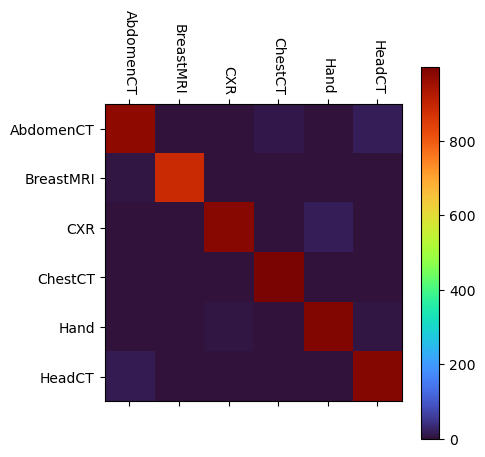

In [48]:
from sklearn.metrics import confusion_matrix

cmat = confusion_matrix(y_true, y_pred)

cax = plt.matshow(cmat, cmap="turbo", interpolation="nearest")
plt.colorbar(cax)

cax.axes.set_xticks(list(range(len(class_names))), class_names, rotation=270)
cax.axes.set_yticks(list(range(len(class_names))), class_names)

plt.show()

## **Summary**

In this notebook, we went through an end-to-end workflow to train the MedNIST dataset using a densenet121 network.  Along the way, you did the following:
- Learned about the MedNIST Data and downloaded it
- Visualized the data to understand the images
- Setup the datasets for use in the model training
- Defined our transforms, datasets, network, and optimizers
- Trained a densenet model and saved the best model as determined by the validation accuracy
- Plotted your training results
- Evaluated your model against the test set
- Ran your final predictions through a classification report to understand more about your final results
- Created a new workflow using Ignite
- Learn more about issues with determinism and how to look out for pitfalls

## **Assignment 1**

We can use Ignite directly with MONAI. The Engine class used here is also extended by MONAI to provide further facilities related to determinism, providing a default training/evaluating iteration implementation, and dealing with the post-processing of data. These types are not necessary so those new to Ignite or already have their own Ignite-based code can integrate MONAI without having to pick up our types.

Requirements:
* Instantiate the SupervisedEvaluator Function
* Instantiate the SupervisedTraining Function
* Run the Ignite + MONAI Training Loop and compare your results to a the standard loop

In [ ]:
from ignite.engine import Events
from ignite.handlers import ModelCheckpoint
from ignite.metrics import Accuracy
from monai.handlers import ROCAUC, ValidationHandler
from monai.engines import SupervisedTrainer, SupervisedEvaluator

train_epochs = 4
iter_losses = []
batch_sizes = []
epoch_loss_values = []
metric_values = []

steps_per_epoch = len(train_ds) // train_loader.batch_size
if len(train_ds) % train_loader.batch_size != 0:
    steps_per_epoch += 1


def roc_auc_trans(x):
    if isinstance(x, list):
        pred = torch.cat([i[0][None, :] for i in x])
        label = torch.cat([i[1][None, :] for i in x])
        return pred, label

    return act(x["pred"]), to_onehot(x["label"])


def prepare_batch(batchdata, device, non_blocking):
    img, classes = batchdata
    return img.to(device), classes.to(device)


evaluator = SupervisedEvaluator(
    # ???
)

trainer = SupervisedTrainer(
    # ???
)


@trainer.on(Events.ITERATION_COMPLETED)
def _end_iter(engine):
    loss = np.average([o["loss"] for o in engine.state.output])
    batch_len = len(engine.state.batch[0])
    epoch = engine.state.epoch
    epoch_len = engine.state.max_epochs
    step = engine.state.iteration + 1
    iter_losses.append(loss)
    batch_sizes.append(batch_len)

    print(f"Epoch {epoch}/{epoch_len}, Step {step}/{steps_per_epoch}, Loss = {loss:.4f}")


@trainer.on(Events.EPOCH_COMPLETED)
def run_validation(engine):
    # the overall average loss must be weighted by batch size
    overall_average_loss = np.average(iter_losses, weights=batch_sizes)
    epoch_loss_values.append(overall_average_loss)

    # clear the contents of iter_losses and batch_sizes for the next epoch
    del iter_losses[:]
    del batch_sizes[:]

    # fetch and report the validation metrics
    roc = evaluator.state.metrics["rocauc"]
    metric_values.append(roc)
    print(f"Evaluation for epoch {engine.state.epoch},  ROCAUC = {roc:.4f}")


trainer.run()

## Assignment 2
### Issues with determinism

MONAI provides `monai.utils.set_determinism` for replicable training
- Easy to not think about, especially in a jupyter / IPython notebook

How many uses of `numpy.random`'s underlying global instance does this notebook have?
- Dataset partitioning
- Image previewing
- MONAI transforms with randomised behaviour can be given / told to create their own internal `numpy.random.RandomState` instances


#### Setting up transforms, revisited
Requirements:
* Update our original compose train function to use set_random_state using the given seed.
* Understand why we don't have to use set_random_state for our original compose validation function.
* Run the Standard PyTorch Training loop with the new Compose function

In [44]:
rseed = 12345678

train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        # RandRotate,
        # RandFlip,
        # RandZoom,
    ]
)

val_transforms = Compose(
    # ???
)

## Assignment 3
### Improving dataset partitioning

Current code results in random numbers of images / labels each time it is run in each category. The solution is to use a deterministic shuffle:

Requirements:
* Utilize the partition_dataset_classes function to properly split the dataset into parts
* Use the parts to create the new image_sets and label_sets
* Create new train, val, and test sets for both image and label

In [ ]:
parts = partition_dataset_classes(
    # ???
)

image_sets = [list(), list(), list()]
label_sets = [list(), list(), list()]

for i, part in enumerate(parts):
    # ???
    
train_x, val_x, test_x = # ???
train_y, val_y, test_y = # ???
print(len(train_x), len(val_x), len(test_x))

## **Next Steps**

You can find more information about everything covered here on our [MONAI Documentation Page](https://docs.monai.io/).  

If you're looking for more examples and tutorials, we have a repo dedicated just to that!  You can find it on our [GitHub Organization Page](https://github.com/Project-MONAI/tutorials).  We also have all of our videos from our first ever MONAI Bootcamp available on our [Youtube Channel](https://www.youtube.com/c/ProjectMONAI)